**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

# Data Preparation

In [2]:
class_name = 'Occupancy'
df = pd.read_csv('occupancy_data/datatraining.txt', skipinitialspace=True, na_values='?', keep_default_na=True)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
def daytime(h):
    if 6 <= h < 13:
        return 'morning'
    elif 13 <= h < 18:
        return 'afternoon'
    elif 18 <= h < 22:
        return 'evening'
    return 'night'

In [4]:
df['daytime'] = [daytime(d.hour) for d in pd.to_datetime(df['date'])]
df['weekend'] = [1 if d.weekday() >= 5 else 0 for d in pd.to_datetime(df['date'])]
columns2remove = ['date']
df.drop(columns2remove, inplace=True, axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,daytime,weekend
1,23.18,27.2720,426.0,721.25,0.004793,1,afternoon,0
2,23.15,27.2675,429.5,714.00,0.004783,1,afternoon,0
3,23.15,27.2450,426.0,713.50,0.004779,1,afternoon,0
4,23.15,27.2000,426.0,708.25,0.004772,1,afternoon,0
5,23.10,27.2000,426.0,704.50,0.004757,1,afternoon,0


In [5]:
df0 = df.copy()

In [6]:
dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
dfY = df[class_name]
df = pd.concat([dfX, dfY], axis=1)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,weekend,daytime=afternoon,daytime=evening,daytime=morning,daytime=night,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,0,1,0,0,0,1
2,23.15,27.2675,429.5,714.00,0.004783,0,1,0,0,0,1
3,23.15,27.2450,426.0,713.50,0.004779,0,1,0,0,0,1
4,23.15,27.2000,426.0,708.25,0.004772,0,1,0,0,0,1
5,23.10,27.2000,426.0,704.50,0.004757,0,1,0,0,0,1


# Data Partitioning

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Normalization

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Sklearn Multilayer Perceptron

In [47]:
from sklearn.neural_network import MLPClassifier

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [12]:
clf = MLPClassifier(random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9930413426115432
F1-score [0.99557407 0.98373206]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1924
           1       0.98      0.99      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.99      0.99      2443
weighted avg       0.99      0.99      0.99      2443



C:\Users\cri98\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


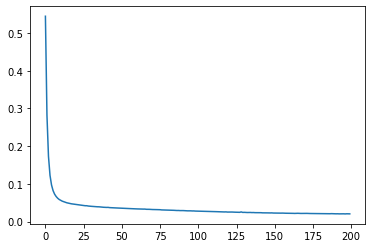

In [13]:
plt.plot(clf.loss_curve_)
plt.show()

In [14]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='tanh', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9897666803110929
F1-score [0.99350143 0.9759384 ]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1924
           1       0.97      0.98      0.98       519

    accuracy                           0.99      2443
   macro avg       0.98      0.99      0.98      2443
weighted avg       0.99      0.99      0.99      2443



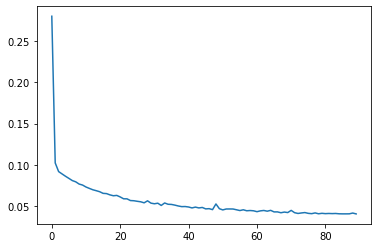

In [15]:
plt.plot(clf.loss_curve_)
plt.show()

In [16]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum", "adam"]

In [17]:
import warnings
from sklearn.exceptions import ConvergenceWarning

constant learning-rate
training set score and loss: 0.788, 0.749526


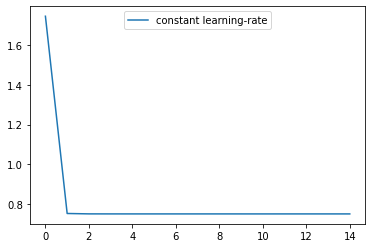

constant with momentum
training set score and loss: 0.788, 24.231273


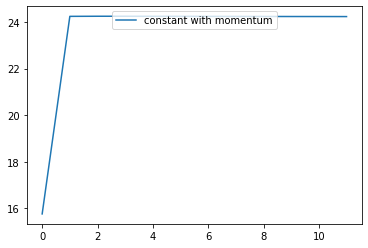

inv-scaling learning-rate
training set score and loss: 0.788, 0.754787


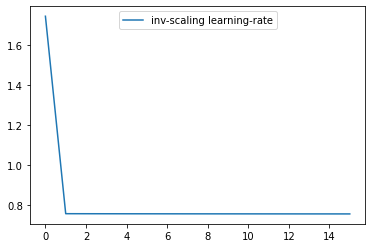

inv-scaling with momentum
training set score and loss: 0.788, 24.244236


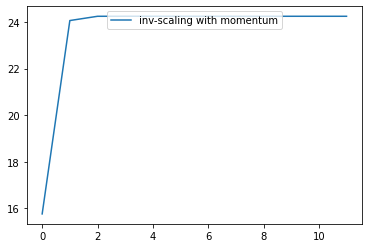

adam
training set score and loss: 0.949, 0.147185


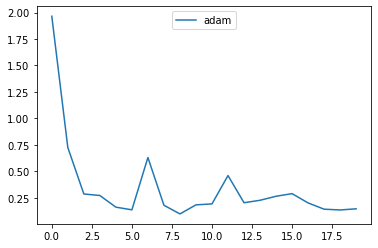

In [18]:
for label, param in zip(labels, params):
    print(label)
    clf = MLPClassifier(random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X, y)

    print("training set score and loss: %.3f, %f" % (clf.score(X, y), clf.loss_))
    plt.plot(clf.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

# Keras Deep Neural Networks

In [20]:
from keras.models import Sequential
from keras.layers import Dense

In [21]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
570/570 [==============================] - 0s 479us/step - loss: 0.0724 - accuracy: 0.9809
Epoch 2/50
570/570 [==============================] - 0s 447us/step - loss: 0.0407 - accuracy: 0.9875
Epoch 3/50
570/570 [==============================] - 0s 436us/step - loss: 0.0367 - accuracy: 0.9870
Epoch 4/50
570/570 [==============================] - 0s 439us/step - loss: 0.0334 - accuracy: 0.9875
Epoch 5/50
570/570 [==============================] - 0s 452us/step - loss: 0.0323 - accuracy: 0.9891
Epoch 6/50
570/570 [==============================] - 0s 455us/step - loss: 0.0297 - accuracy: 0.9886
Epoch 7/50
570/570 [==============================] - 0s 425us/step - loss: 0.0289 - accuracy: 0.9900
Epoch 8/50
570/570 [==============================] - 0s 437us/step - loss: 0.0271 - accuracy: 0.9905
Epoch 9/50
570/570 [==============================] - 0s 450us/step - loss: 0.0266 - accuracy: 0.9904
Epoch 10/50
570/570 [==============================] - 0s 460us/step - loss: 0.026

In [23]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
114/114 [==============================] - 0s 448us/step - loss: 0.1431 - accuracy: 0.9696
Epoch 2/50
114/114 [==============================] - 0s 431us/step - loss: 0.0460 - accuracy: 0.9874
Epoch 3/50
114/114 [==============================] - 0s 579us/step - loss: 0.0397 - accuracy: 0.9877
Epoch 4/50
114/114 [==============================] - 0s 483us/step - loss: 0.0375 - accuracy: 0.9875
Epoch 5/50
114/114 [==============================] - 0s 513us/step - loss: 0.0359 - accuracy: 0.9877
Epoch 6/50
114/114 [==============================] - 0s 553us/step - loss: 0.0342 - accuracy: 0.9879
Epoch 7/50
114/114 [==============================] - 0s 492us/step - loss: 0.0330 - accuracy: 0.9877
Epoch 8/50
114/114 [==============================] - 0s 522us/step - loss: 0.0313 - accuracy: 0.9874
Epoch 9/50
114/114 [==============================] - 0s 496us/step - loss: 0.0300 - accuracy: 0.9893
Epoch 10/50
114/114 [==============================] - 0s 548us/step - loss: 0.029

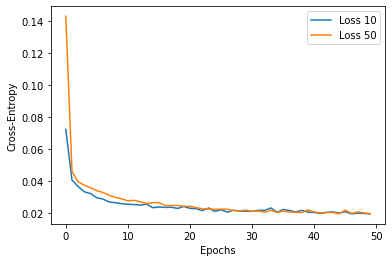

In [24]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [25]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

77/77 [==============================] - 0s 367us/step - loss: 0.0194 - accuracy: 0.9926
Loss 0.021506, Accuracy 0.991813
Loss 0.019388, Accuracy 0.992632


In [26]:
y_pred = model1.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.787556283258289
F1-score [0.88115411 0.        ]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      1924
           1       0.00      0.00      0.00       519

    accuracy                           0.79      2443
   macro avg       0.39      0.50      0.44      2443
weighted avg       0.62      0.79      0.69      2443



C:\Users\cri98\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=10).history

Epoch 1/1000
570/570 [==============================] - 0s 838us/step - loss: 0.0700 - accuracy: 0.9833 - val_loss: 0.0433 - val_accuracy: 0.9881
Epoch 2/1000
570/570 [==============================] - 0s 586us/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.0344 - val_accuracy: 0.9910
Epoch 3/1000
570/570 [==============================] - 0s 615us/step - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.0292 - val_accuracy: 0.9889
Epoch 4/1000
570/570 [==============================] - 0s 620us/step - loss: 0.0335 - accuracy: 0.9877 - val_loss: 0.0289 - val_accuracy: 0.9894
Epoch 5/1000
570/570 [==============================] - 0s 627us/step - loss: 0.0327 - accuracy: 0.9881 - val_loss: 0.0297 - val_accuracy: 0.9898
Epoch 6/1000
570/570 [==============================] - 0s 605us/step - loss: 0.0302 - accuracy: 0.9898 - val_loss: 0.0262 - val_accuracy: 0.9898
Epoch 7/1000
570/570 [==============================] - 0s 591us/step - loss: 0.0281 - accuracy: 0.9898 - val_loss: 0.0258 -

Epoch 57/1000
570/570 [==============================] - 0s 595us/step - loss: 0.0193 - accuracy: 0.9928 - val_loss: 0.0198 - val_accuracy: 0.9935
Epoch 58/1000
570/570 [==============================] - 0s 727us/step - loss: 0.0189 - accuracy: 0.9930 - val_loss: 0.0251 - val_accuracy: 0.9902
Epoch 59/1000
570/570 [==============================] - 0s 553us/step - loss: 0.0195 - accuracy: 0.9930 - val_loss: 0.0187 - val_accuracy: 0.9922
Epoch 60/1000
570/570 [==============================] - 0s 601us/step - loss: 0.0188 - accuracy: 0.9939 - val_loss: 0.0192 - val_accuracy: 0.9922
Epoch 61/1000
570/570 [==============================] - 0s 693us/step - loss: 0.0204 - accuracy: 0.9928 - val_loss: 0.0187 - val_accuracy: 0.9926
Epoch 62/1000
570/570 [==============================] - 0s 640us/step - loss: 0.0192 - accuracy: 0.9930 - val_loss: 0.0221 - val_accuracy: 0.9889
Epoch 63/1000
570/570 [==============================] - 0s 622us/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0

570/570 [==============================] - 0s 577us/step - loss: 0.0160 - accuracy: 0.9946 - val_loss: 0.0202 - val_accuracy: 0.9918
Epoch 168/1000
570/570 [==============================] - 0s 532us/step - loss: 0.0172 - accuracy: 0.9940 - val_loss: 0.0231 - val_accuracy: 0.9926
Epoch 169/1000
570/570 [==============================] - 0s 566us/step - loss: 0.0160 - accuracy: 0.9947 - val_loss: 0.0321 - val_accuracy: 0.9877
Epoch 170/1000
570/570 [==============================] - 0s 571us/step - loss: 0.0162 - accuracy: 0.9940 - val_loss: 0.0237 - val_accuracy: 0.9894
Epoch 171/1000
570/570 [==============================] - 0s 534us/step - loss: 0.0173 - accuracy: 0.9930 - val_loss: 0.0247 - val_accuracy: 0.9914
Epoch 172/1000
570/570 [==============================] - 0s 556us/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.0246 - val_accuracy: 0.9922
Epoch 173/1000
570/570 [==============================] - 0s 570us/step - loss: 0.0151 - accuracy: 0.9953 - val_loss: 0.0219 - 

570/570 [==============================] - 0s 600us/step - loss: 0.0142 - accuracy: 0.9954 - val_loss: 0.0235 - val_accuracy: 0.9930
Epoch 278/1000
570/570 [==============================] - 0s 621us/step - loss: 0.0140 - accuracy: 0.9951 - val_loss: 0.0261 - val_accuracy: 0.9910
Epoch 279/1000
570/570 [==============================] - 0s 563us/step - loss: 0.0144 - accuracy: 0.9951 - val_loss: 0.0280 - val_accuracy: 0.9914
Epoch 280/1000
570/570 [==============================] - 0s 622us/step - loss: 0.0159 - accuracy: 0.9946 - val_loss: 0.0263 - val_accuracy: 0.9926
Epoch 281/1000
570/570 [==============================] - 0s 581us/step - loss: 0.0140 - accuracy: 0.9951 - val_loss: 0.0213 - val_accuracy: 0.9914
Epoch 282/1000
570/570 [==============================] - 0s 556us/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.0191 - val_accuracy: 0.9930
Epoch 283/1000
570/570 [==============================] - 0s 602us/step - loss: 0.0140 - accuracy: 0.9944 - val_loss: 0.0212 - 

570/570 [==============================] - 0s 628us/step - loss: 0.0141 - accuracy: 0.9946 - val_loss: 0.0259 - val_accuracy: 0.9930
Epoch 388/1000
570/570 [==============================] - 0s 638us/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0259 - val_accuracy: 0.9922
Epoch 389/1000
570/570 [==============================] - 0s 553us/step - loss: 0.0137 - accuracy: 0.9953 - val_loss: 0.0230 - val_accuracy: 0.9939
Epoch 390/1000
570/570 [==============================] - 0s 607us/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0221 - val_accuracy: 0.9922
Epoch 391/1000
570/570 [==============================] - 0s 605us/step - loss: 0.0147 - accuracy: 0.9954 - val_loss: 0.0265 - val_accuracy: 0.9914
Epoch 392/1000
570/570 [==============================] - 0s 631us/step - loss: 0.0139 - accuracy: 0.9953 - val_loss: 0.0255 - val_accuracy: 0.9930
Epoch 393/1000
570/570 [==============================] - 0s 646us/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0.0298 - 

570/570 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.99 - 0s 570us/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0319 - val_accuracy: 0.9914
Epoch 498/1000
570/570 [==============================] - 0s 607us/step - loss: 0.0135 - accuracy: 0.9951 - val_loss: 0.0310 - val_accuracy: 0.9914
Epoch 499/1000
570/570 [==============================] - 0s 607us/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.0273 - val_accuracy: 0.9918
Epoch 500/1000
570/570 [==============================] - 0s 553us/step - loss: 0.0140 - accuracy: 0.9949 - val_loss: 0.0255 - val_accuracy: 0.9930
Epoch 501/1000
570/570 [==============================] - 0s 606us/step - loss: 0.0129 - accuracy: 0.9951 - val_loss: 0.0312 - val_accuracy: 0.9922
Epoch 502/1000
570/570 [==============================] - 0s 593us/step - loss: 0.0135 - accuracy: 0.9947 - val_loss: 0.0316 - val_accuracy: 0.9910
Epoch 503/1000
570/570 [==============================] - 0s 585us/step - loss: 0.013

570/570 [==============================] - 0s 589us/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.0323 - val_accuracy: 0.9918
Epoch 608/1000
570/570 [==============================] - 0s 546us/step - loss: 0.0124 - accuracy: 0.9956 - val_loss: 0.0294 - val_accuracy: 0.9943
Epoch 609/1000
570/570 [==============================] - 0s 551us/step - loss: 0.0123 - accuracy: 0.9961 - val_loss: 0.0341 - val_accuracy: 0.9922
Epoch 610/1000
570/570 [==============================] - 0s 593us/step - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.0291 - val_accuracy: 0.9922
Epoch 611/1000
570/570 [==============================] - 0s 547us/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 0.0325 - val_accuracy: 0.9914
Epoch 612/1000
570/570 [==============================] - 0s 565us/step - loss: 0.0118 - accuracy: 0.9956 - val_loss: 0.0341 - val_accuracy: 0.9935
Epoch 613/1000
570/570 [==============================] - 0s 602us/step - loss: 0.0137 - accuracy: 0.9947 - val_loss: 0.0310 - 

570/570 [==============================] - 0s 610us/step - loss: 0.0116 - accuracy: 0.9958 - val_loss: 0.0475 - val_accuracy: 0.9935
Epoch 718/1000
570/570 [==============================] - 0s 586us/step - loss: 0.0130 - accuracy: 0.9951 - val_loss: 0.0457 - val_accuracy: 0.9926
Epoch 719/1000
570/570 [==============================] - 0s 637us/step - loss: 0.0116 - accuracy: 0.9960 - val_loss: 0.0328 - val_accuracy: 0.9926
Epoch 720/1000
570/570 [==============================] - 0s 636us/step - loss: 0.0121 - accuracy: 0.9956 - val_loss: 0.0503 - val_accuracy: 0.9914
Epoch 721/1000
570/570 [==============================] - 0s 564us/step - loss: 0.0117 - accuracy: 0.9958 - val_loss: 0.0482 - val_accuracy: 0.9914
Epoch 722/1000
570/570 [==============================] - 0s 586us/step - loss: 0.0136 - accuracy: 0.9958 - val_loss: 0.0435 - val_accuracy: 0.9914
Epoch 723/1000
570/570 [==============================] - 0s 598us/step - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.0403 - 

570/570 [==============================] - 0s 659us/step - loss: 0.0109 - accuracy: 0.9956 - val_loss: 0.0422 - val_accuracy: 0.9910
Epoch 828/1000
570/570 [==============================] - 0s 623us/step - loss: 0.0116 - accuracy: 0.9958 - val_loss: 0.0483 - val_accuracy: 0.9922
Epoch 829/1000
570/570 [==============================] - 0s 645us/step - loss: 0.0114 - accuracy: 0.9956 - val_loss: 0.0368 - val_accuracy: 0.9935
Epoch 830/1000
570/570 [==============================] - 0s 668us/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.0436 - val_accuracy: 0.9935
Epoch 831/1000
570/570 [==============================] - 0s 618us/step - loss: 0.0114 - accuracy: 0.9953 - val_loss: 0.0359 - val_accuracy: 0.9922
Epoch 832/1000
570/570 [==============================] - 0s 664us/step - loss: 0.0113 - accuracy: 0.9960 - val_loss: 0.0351 - val_accuracy: 0.9943
Epoch 833/1000
570/570 [==============================] - 0s 619us/step - loss: 0.0125 - accuracy: 0.9956 - val_loss: 0.0333 - 

570/570 [==============================] - 0s 611us/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.0432 - val_accuracy: 0.9926
Epoch 938/1000
570/570 [==============================] - 0s 586us/step - loss: 0.0109 - accuracy: 0.9970 - val_loss: 0.0336 - val_accuracy: 0.9922
Epoch 939/1000
570/570 [==============================] - 0s 557us/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0378 - val_accuracy: 0.9930
Epoch 940/1000
570/570 [==============================] - 0s 612us/step - loss: 0.0106 - accuracy: 0.9965 - val_loss: 0.0439 - val_accuracy: 0.9926
Epoch 941/1000
570/570 [==============================] - 0s 613us/step - loss: 0.0115 - accuracy: 0.9958 - val_loss: 0.0388 - val_accuracy: 0.9902
Epoch 942/1000
570/570 [==============================] - 0s 556us/step - loss: 0.0120 - accuracy: 0.9963 - val_loss: 0.0485 - val_accuracy: 0.9930
Epoch 943/1000
570/570 [==============================] - 0s 593us/step - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.0440 - 

In [28]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

77/77 [==============================] - 0s 496us/step - loss: 0.0468 - accuracy: 0.9918
Loss 0.021506, Accuracy 0.991813
Loss 0.019388, Accuracy 0.992632
Loss 0.046756, Accuracy 0.991813


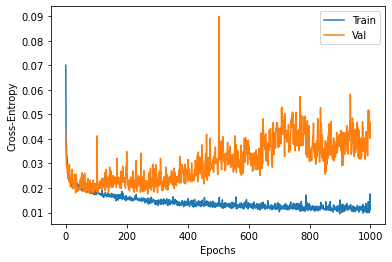

In [29]:
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Early Stopping

In [31]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

The most relevant arguments are:

* monitor: quantity to be monitored
* patience: number of epochs with no improvement after which training will be stopped

In [32]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
456/456 [==============================] - 0s 823us/step - loss: 0.0774 - accuracy: 0.9816 - val_loss: 0.0624 - val_accuracy: 0.9833
Epoch 2/100
456/456 [==============================] - 0s 609us/step - loss: 0.0423 - accuracy: 0.9884 - val_loss: 0.0476 - val_accuracy: 0.9842
Epoch 3/100
456/456 [==============================] - 0s 595us/step - loss: 0.0367 - accuracy: 0.9875 - val_loss: 0.0434 - val_accuracy: 0.9851
Epoch 4/100
456/456 [==============================] - 0s 584us/step - loss: 0.0342 - accuracy: 0.9877 - val_loss: 0.0402 - val_accuracy: 0.9842
Epoch 5/100
456/456 [==============================] - 0s 605us/step - loss: 0.0327 - accuracy: 0.9871 - val_loss: 0.0416 - val_accuracy: 0.9851
Epoch 6/100
456/456 [==============================] - 0s 613us/step - loss: 0.0297 - accuracy: 0.9901 - val_loss: 0.0419 - val_accuracy: 0.9842
Epoch 7/100
456/456 [==============================] - 0s 595us/step - loss: 0.0287 - accuracy: 0.9893 - val_loss: 0.0379 - val_ac

In [33]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

77/77 [==============================] - 0s 593us/step - loss: 0.0287 - accuracy: 0.9894
Loss 0.021506, Accuracy 0.991813
Loss 0.019388, Accuracy 0.992632
Loss 0.046756, Accuracy 0.991813
Loss 0.028725, Accuracy 0.989357


## L2 Regularization

In [34]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [35]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
456/456 [==============================] - 0s 930us/step - loss: 1.0357 - accuracy: 0.9794 - val_loss: 0.3995 - val_accuracy: 0.8746
Epoch 2/100
456/456 [==============================] - 0s 678us/step - loss: 0.2934 - accuracy: 0.9855 - val_loss: 0.2784 - val_accuracy: 0.9868
Epoch 3/100
456/456 [==============================] - 0s 641us/step - loss: 0.2245 - accuracy: 0.9776 - val_loss: 0.2440 - val_accuracy: 0.9868
Epoch 4/100
456/456 [==============================] - 0s 707us/step - loss: 0.1921 - accuracy: 0.9871 - val_loss: 0.1140 - val_accuracy: 0.9737
Epoch 5/100
456/456 [==============================] - 0s 680us/step - loss: 0.2004 - accuracy: 0.9794 - val_loss: 0.2354 - val_accuracy: 0.9842
Epoch 6/100
456/456 [==============================] - 0s 612us/step - loss: 0.1852 - accuracy: 0.9846 - val_loss: 0.2267 - val_accuracy: 0.9868
Epoch 7/100
456/456 [==============================] - 0s 636us/step - loss: 0.2011 - accuracy: 0.9785 - val_loss: 0.2328 - val_ac

In [36]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [37]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

Epoch 1/100
456/456 [==============================] - 0s 956us/step - loss: 0.2316 - accuracy: 0.9726 - val_loss: 0.2014 - val_accuracy: 0.9868
Epoch 2/100
456/456 [==============================] - 0s 778us/step - loss: 0.1972 - accuracy: 0.9833 - val_loss: 0.2006 - val_accuracy: 0.9868
Epoch 3/100
456/456 [==============================] - 0s 672us/step - loss: 0.1739 - accuracy: 0.9871 - val_loss: 0.2006 - val_accuracy: 0.9868
Epoch 4/100
456/456 [==============================] - 0s 727us/step - loss: 0.1808 - accuracy: 0.9882 - val_loss: 0.2006 - val_accuracy: 0.9868
Epoch 5/100
456/456 [==============================] - 0s 749us/step - loss: 0.1779 - accuracy: 0.9882 - val_loss: 0.2006 - val_accuracy: 0.9868
Epoch 6/100
456/456 [==============================] - 0s 678us/step - loss: 0.1752 - accuracy: 0.9879 - val_loss: 0.2008 - val_accuracy: 0.9868
Epoch 7/100
456/456 [==============================] - 0s 694us/step - loss: 0.1856 - accuracy: 0.9868 - val_loss: 0.2006 - val_ac

In [38]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

77/77 [==============================] - 0s 412us/step - loss: 0.1436 - accuracy: 0.9906


In [39]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.019843, Accuracy 0.992632
Loss 0.112273, Accuracy 0.975440
Loss 0.143627, Accuracy 0.990585


## Hyper-Parameter Tuning

In [40]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [41]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [42]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [43]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

48/48 [==============================] - 0s 362us/step - loss: 0.2207 - accuracy: 0.9855


In [44]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.145603 using {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 64, 'activation': 'tanh'}
0.177595 (0.016938) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 128, 'activation': 'relu'}
0.145603 (0.040358) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 64, 'activation': 'tanh'}
1.207406 (1.492723) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 64, 'activation': 'relu'}
1.186600 (1.421386) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 32, 'activation': 'relu'}
0.181500 (0.027732) with: {'optimizer': 'adam', 'n_layers': 3, 'h_dim': 32, 'activation': 'tanh'}


In [45]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

77/77 [==============================] - 0s 329us/step - loss: 0.1370 - accuracy: 0.9894
Loss 0.137008, Accuracy 0.989357
